In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random

import torch.optim as optim
from torch.optim import lr_scheduler

from collections import OrderedDict
from tqdm import tqdm

from torchsummary import summary

from albumentations.augmentations import transforms, Normalize
from albumentations import Flip, RandomRotate90, Resize
from albumentations.core.composition import Compose, OneOf

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
SIZE = 256
batch_size = 1
base_dir = '' # Local
num_workers = 1
lr = 0.0001
min_lr = 0.00001
epochs = 50
early_stopping = 5
# base_dir = '/content/' # Colab
root_path = os.path.join(base_dir, 'breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/')
semantic = False
device = torch.device('cuda:0')

classes = ['normal', 'benign', 'malignant']
labels = []
num_classes = 3 if semantic else 1

if semantic:
    labels = classes
else:
    labels = ['cancer']

In [3]:
all_images = glob.glob(os.path.join(root_path, "**/*).png"), recursive=True)

image_paths = []
mask_paths = []

for path in all_images:
    if 'normal' in path:
        continue

    image_paths.append(path)
    cur_mask_path = []
    mask_path_1 = path.replace('.png', '_mask.png')
    mask_path_2 = path.replace('.png', '_mask_1.png')
    cur_mask_path.append(mask_path_1)
    if os.path.exists(mask_path_2):
        cur_mask_path.append(mask_path_2)
    mask_paths.append(cur_mask_path)

image_paths = np.array(image_paths)
mask_paths = np.array(mask_paths, dtype=object)

In [4]:
from data import *
from metrics import *
from utils import *
from models import *

dataset = BUSIDataset(image_paths=image_paths, mask_paths=mask_paths)

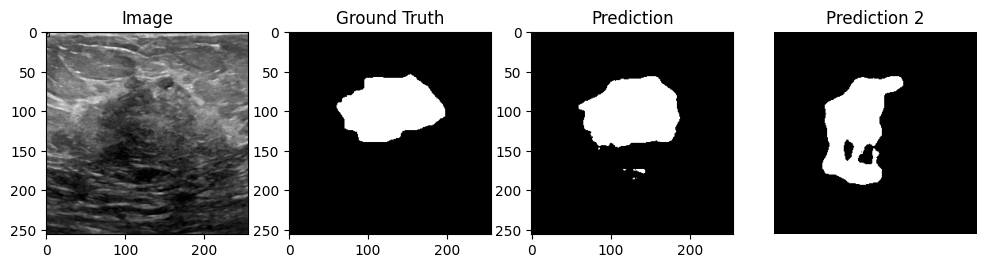

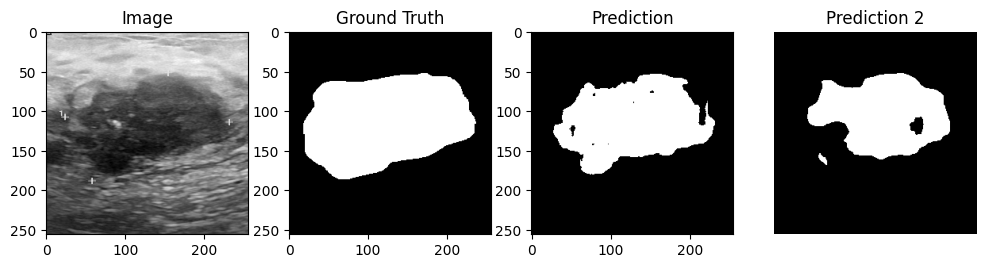

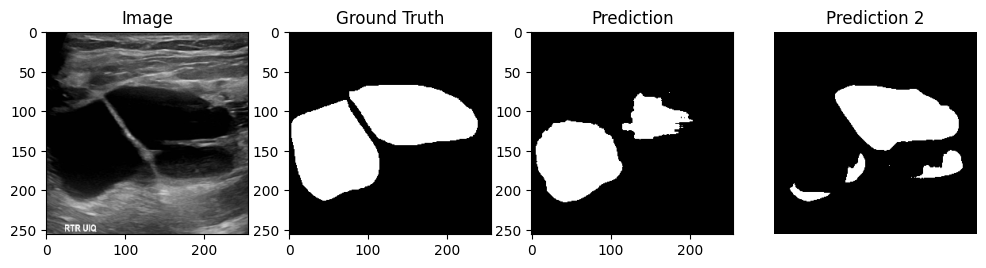

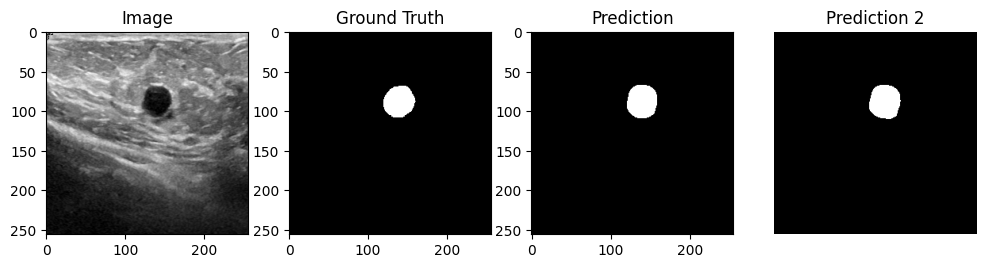

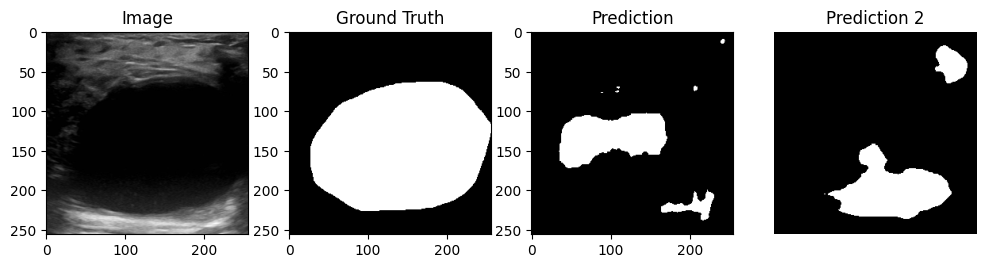

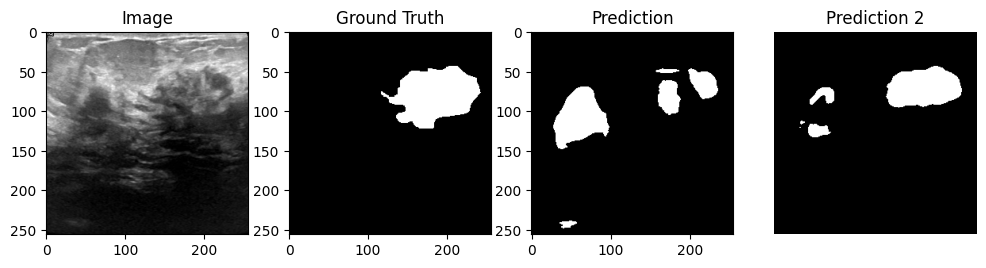

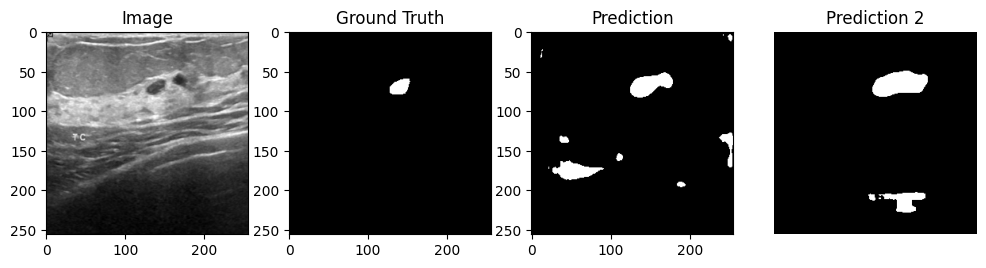

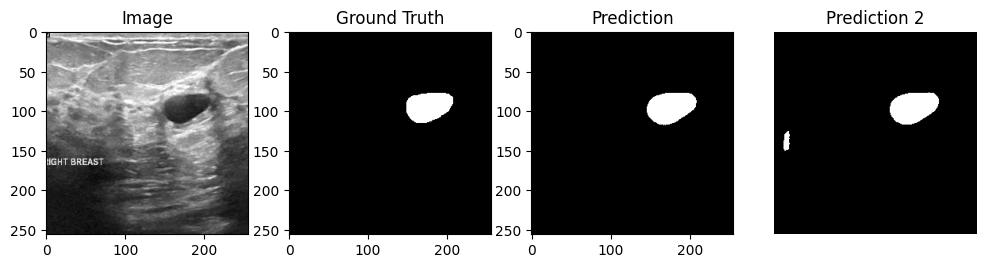

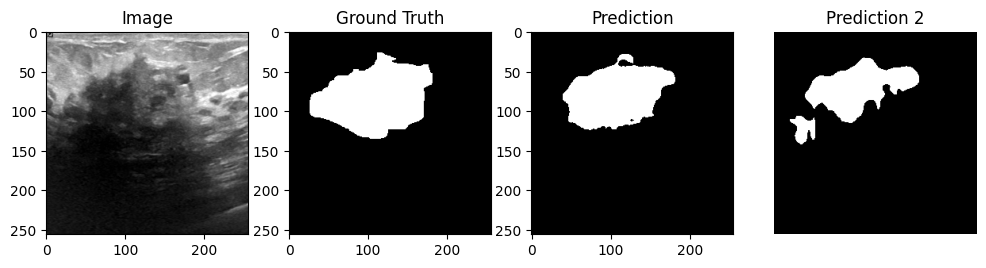

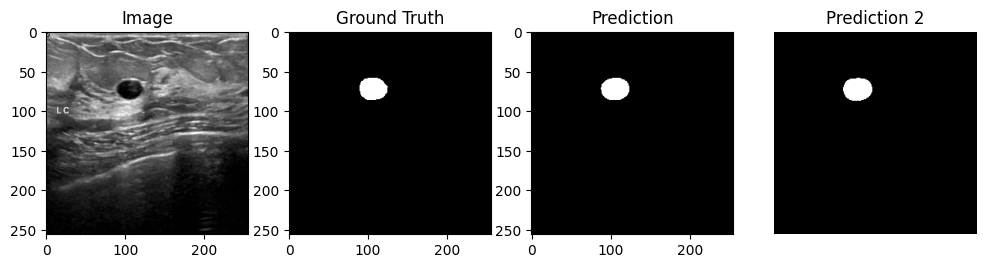

In [5]:
import models

def compare_models(model1_name, model2_name, count):
    model1 = models.__dict__[model1_name](n_channels=1, n_classes=1).cuda()
    model2 = models.__dict__[model2_name](n_channels=1, n_classes=1).cuda()

    model1.load_state_dict(torch.load(f'model_files/{model1_name}/model.pth'))
    model2.load_state_dict(torch.load(f'model_files/{model2_name}/model.pth'))

    for _ in range(count):

        idx = random.randint(0, len(image_paths) - 1)

        image, mask = load_tensor(image_paths[idx], mask_paths[idx])
        mask = mask.unsqueeze(0)
        image = image.unsqueeze(0)
        model1_prediction = model1(image)
        model2_prediction = model2(image)
        compare_prediction(image, mask, model1_prediction, model2_prediction)

compare_models('UNet', 'MR_UNet', 10)

In [6]:
# import the file "test_log.csv" and for a given name and size, print the mean dice score, standard deviation, mean iou and standard deviation
import pandas as pd

def print_stats(name, size):
    path = f"/home/cse/Documents/g1/big_pc_trained-files/test_log.csv"
    log = pd.read_csv(path)
    log = log[log['Size'] == size]
    log = log[log['Name'] == name]
    print(f"Model: {name}, Input Size: {size} x {size}")
    print(f"Dice: {log['Dice'].mean()} +- {log['Dice'].std()}")
    print(f"IoU: {log['IoU'].mean()} +- {log['IoU'].std()}")
    print(f"Parameters: {log['Parameters'].mean() / 1e6}M")

    print()

print_stats('UNet', 256)
print_stats('Wavelet_UNet', 256)
print_stats('Wavelet_UNet_All', 256)
print_stats('MR_UNet', 256)
print_stats('Feature_Fusion_UNet', 256)

Model: UNet, Input Size: 256 x 256
Dice: 0.7738876720411098 +- 0.018194769744529257
IoU: 0.6390139559620933 +- 0.019652593332363275
Parameters: 31.036481M

Model: Wavelet_UNet, Input Size: 256 x 256
Dice: 0.7589397239996318 +- 0.006620522935486082
IoU: 0.6210064532912797 +- 0.007913213714759148
Parameters: 17.261825M

Model: Wavelet_UNet_All, Input Size: 256 x 256
Dice: 0.6297855619022366 +- 0.005840730230519411
IoU: 0.46638270910428664 +- 0.0023117989784332245
Parameters: 17.263941M

Model: MR_UNet, Input Size: 256 x 256
Dice: 0.787391366537193 +- 0.01211125480842672
IoU: 0.6524043040736747 +- 0.014365233487788408
Parameters: 81.204161M

Model: Feature_Fusion_UNet, Input Size: 256 x 256
Dice: 0.6923407730923827 +- 0.056698964628462356
IoU: 0.5378045458943091 +- 0.06582060842674745
Parameters: 43.572801M



[[[[-0.019041   -0.0203181  -0.02200503 ... -0.03089787 -0.03260885
    -0.02561036]
   [-0.02045375 -0.02151755 -0.02456173 ... -0.03257804 -0.03524511
    -0.02593213]
   [-0.01900177 -0.02124802 -0.02494444 ... -0.03532322 -0.03759757
    -0.02797907]
   ...
   [-0.01982093 -0.02012529 -0.02098774 ... -0.02129786 -0.02165382
    -0.01992243]
   [-0.02087183 -0.02100026 -0.02153551 ... -0.02164067 -0.02215518
    -0.02006842]
   [-0.02062814 -0.02131531 -0.02195117 ... -0.02233269 -0.02199599
    -0.02001201]]]]


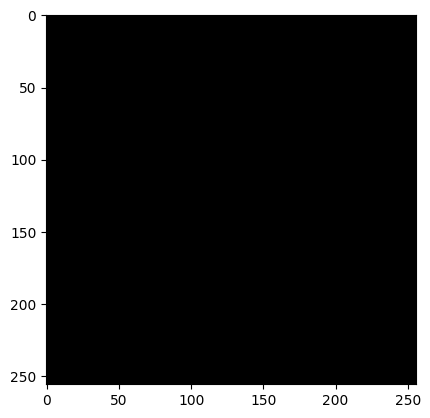

In [7]:
import models
from utils import load_tensor
import torch
import numpy as np
import matplotlib.pyplot as plt

model = models.UNet3Plus(n_channels=1, n_classes=1).cuda()
image = '/home/cse/Documents/g1/git-repo/wavelet-ensemble-unet/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (1).png'
mask = '/home/cse/Documents/g1/git-repo/wavelet-ensemble-unet/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (1)_mask.png'
image, mask = load_tensor(image, mask)
image = image.unsqueeze(0)
mask = mask.unsqueeze(0)
# model.load_state_dict(torch.load('model_files/UNet2Plus/model.pth'))
model.eval()
model_prediction = model(image)
# convert model_prediction to a numpy array
model_prediction = model_prediction.cpu().detach().numpy()

print(model_prediction)
plt.imshow(model_prediction[0, 0, :, :], cmap='gray', vmin=0, vmax=1)